<a href="https://colab.research.google.com/github/Loinen/geodata_analysis/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорты и загрузка данных


In [ ]:
# for colab
# ! pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.ar_model import AutoReg, ar_select_order

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import scipy.stats as scs

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from scipy.optimize import minimize
from numpy.polynomial import Polynomial as P

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

    TEMP - Mean temperature (.1 Fahrenheit)
    SLP - Mean sea level pressure for the day in millibars to tenths. Missing = 9999.9 (.1 mb)
    WDSP – Mean wind speed (.1 knots)

In [ ]:
random.seed(42)
original_data = pd.read_csv("https://raw.githubusercontent.com/Loinen/geodata_analysis/main/data/data_spb.csv", index_col=1, na_values='NA', usecols=['STATION', 'DATE', 'TEMP', 'SLP'])
original_data

,STATION,SLP,TEMP
DATE,,,
1990-02-03,26060099999,1010.5,34.3
1990-02-13,26060099999,1002.7,31.8
1990-04-29,26060099999,1014.9,50.4
1990-01-01,26063099999,1020.3,27.5
1990-01-02,26063099999,1020.4,22.2
...,...,...,...
2019-12-31,26072099999,993.5,35.8
2020-01-01,26063099999,9999.9,33.1
2020-01-02,26063099999,9999.9,38.7


In [ ]:
original_data = original_data.loc[original_data.STATION == 26063099999]
original_data = original_data.drop(columns='STATION')

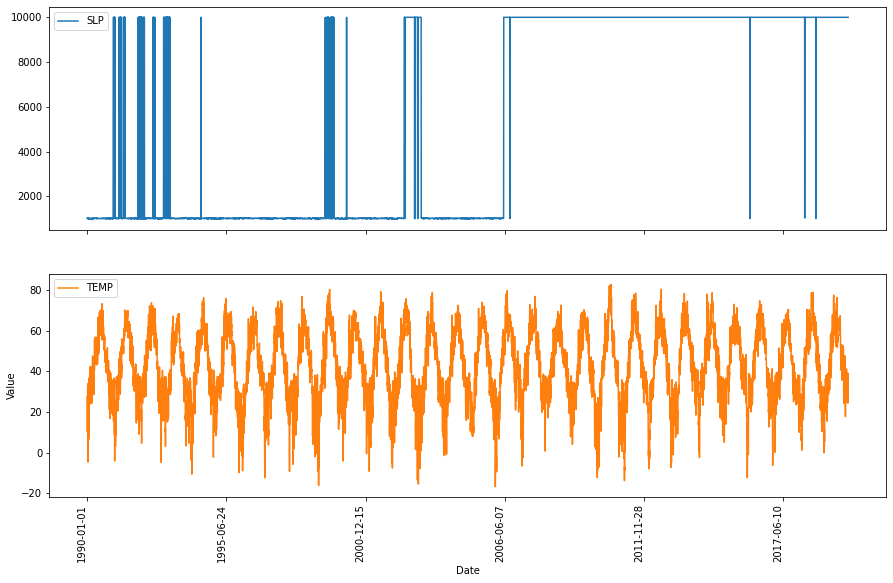

In [ ]:
original_data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()
# we can see a lot of gaps at the end

In [ ]:
# удаление пропущенных значений + убираем все после 2006 года
original_data = original_data.loc[:'2006-01-01']

data = original_data.copy()
missing_vals = data.loc[data.SLP==9999.9]
data = data.replace(9999.9, np.nan, regex=True)
data = data.dropna(subset=['SLP'])

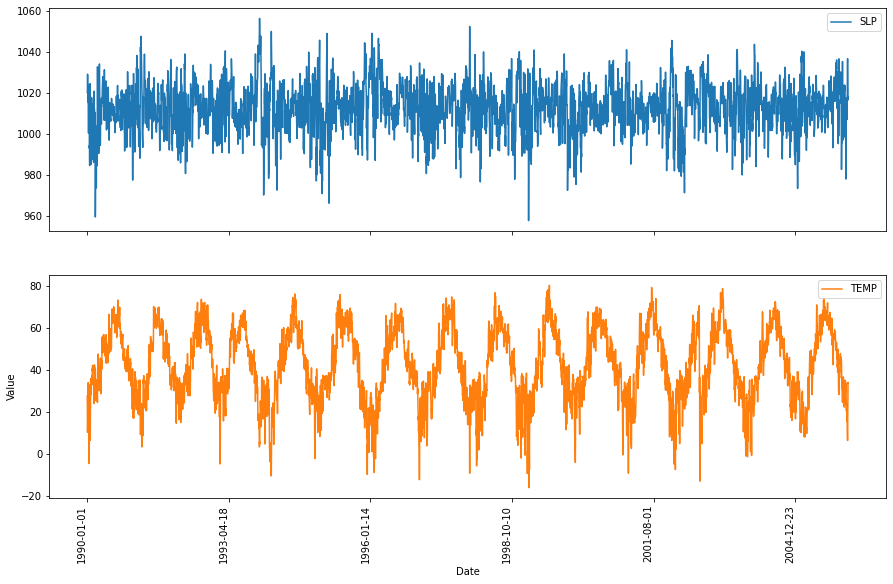

In [ ]:
data.plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
data.shape

(5375, 2)

# Приводим ряд к стационарному

In [ ]:
# Остаются данные без пропусков.
cut_data = original_data['1994-07-01':'1999-05-01'].copy()
data_array=cut_data['SLP'].values

In [ ]:
# Проверяем на стационарность. Считаем единичные корни

autoreg_model = AutoReg(cut_data['SLP'], lags=20, trend='n')
autoreg_model_fit = autoreg_model.fit()

p = P(np.flip(np.append(autoreg_model_fit.params.values,1)))
print(abs(p.roots()))

print(autoreg_model_fit.params)

[0.96521455 0.96521455 0.97073093 0.97073093 0.97519966 0.97519966
 0.99078723 0.99078723 0.99292342 0.99292342 1.00460514 1.00460514
 1.00294382 1.00294382 1.00934933 1.00934933 1.00961009 1.00961009
 1.01102717 1.01102717]
SLP.L1     1.148458
SLP.L2    -0.485189
SLP.L3     0.224299
SLP.L4    -0.082642
SLP.L5     0.040498
SLP.L6    -0.008075
SLP.L7     0.013844
SLP.L8     0.027225
SLP.L9     0.020814
SLP.L10   -0.038885
SLP.L11    0.033489
SLP.L12    0.019330
SLP.L13    0.013589
SLP.L14    0.019814
SLP.L15    0.009313
SLP.L16   -0.006706
SLP.L17    0.025629
SLP.L18   -0.000816
SLP.L19    0.001460
SLP.L20    0.024541
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# рисует автокорреляцию
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        
        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.000000


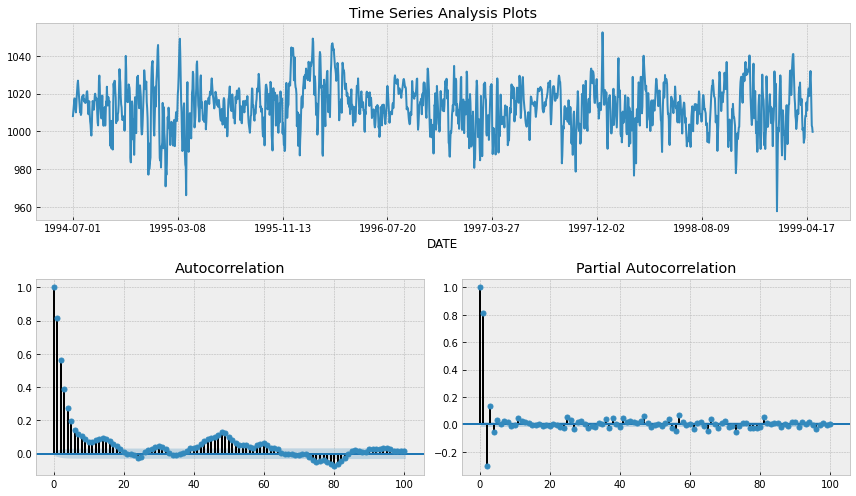

In [ ]:
# Автокорреляция для давления.
tsplot(cut_data['SLP'], lags=100)

In [ ]:
def poly(coeffs,t):
  val=0
  for i,coeff in enumerate(coeffs):
    val+=t**i*coeff
  return val

def square_func(coeffs,data):
  return np.mean(np.sqrt(np.sum([(data[t]-poly(coeffs,t))**2 for t in range(len(data))])))

def approximate_poly(degree,data):
  opt=minimize(square_func,np.zeros(degree+1),args=(data))
  return opt
  
def polyplot(data,coeffs):
  plt.plot(data)
  plt.plot([poly(coeffs,t) for t in range(len(data))])

In [ ]:
opt=approximate_poly(1,data_array)

In [ ]:
degree = 1
opt_coeffs = approximate_poly(degree,data_array).x
opt_coeffs_press = opt_coeffs
datatrend_press = np.array([poly(opt_coeffs,t) for t in range(len(data_array))])
datadetrend_press = np.array(data_array)-datatrend_press

In [ ]:
spectre=np.fft.fft(datadetrend_press)
np.mean(datadetrend_press)

5.963422812597886e-07

Text(0, 0.5, 'Value (.1 millibars)')

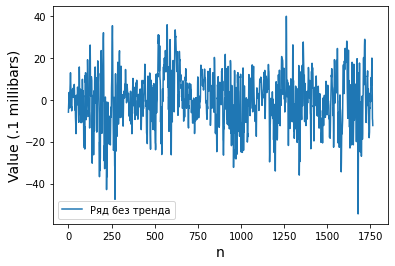

In [ ]:
plt.plot(datadetrend_press, label="Ряд без тренда")
plt.legend()
plt.xlabel('n', fontsize=14)
plt.ylabel('Value (.1 millibars)', fontsize=14)

Text(0, 0.5, 'Amplitude')

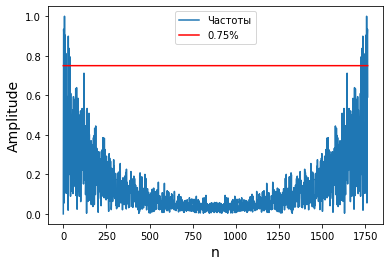

In [ ]:
plt.plot(np.abs(spectre)/np.max(np.abs(spectre)), label="Частоты")
plt.plot(0.75*np.ones(len(spectre)),c='r', label="0.75%")
plt.legend()
plt.xlabel('n', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

In [ ]:
index_spectre = np.where(np.abs(spectre)/np.max(np.abs(spectre))>0.75)

In [ ]:
spectre_jr = []
for index in index_spectre:
    spectre_jr.append(np.abs(spectre[index]))

print(spectre_jr)

[array([2388.65801224, 2322.18746419, 2557.27198054, 2312.33926817,
       2074.73075855, 2299.24555005, 2141.12424641, 2031.71020377,
       2031.71020377, 2141.12424641, 2299.24555005, 2074.73075855,
       2312.33926817, 2557.27198054, 2322.18746419, 2388.65801224])]


In [ ]:
import cmath

frqs = np.fft.fftfreq(len(spectre))
frqs = frqs[index_spectre]

phases = []
for sp in spectre:
    phases.append(cmath.phase(sp))  


In [ ]:
def sinusiod(x, spectre, phase, frq):
    res = 0
    for i, sp in enumerate(spectre):
        res += sp * np.sin((2 * np.pi) * frq[i] * x + phase[i])
        
    return -res / 1000

In [ ]:
mainspectre=np.zeros(len(spectre),dtype=np.complex128)
mainspectre[np.abs(spectre)/np.max(np.abs(spectre))>0.75]=spectre[np.abs(spectre)/np.max(np.abs(spectre))>0.75]

In [ ]:
dataseason_press=np.real(np.fft.ifft(mainspectre))

Text(0, 0.5, 'Value (.1 millibars)')

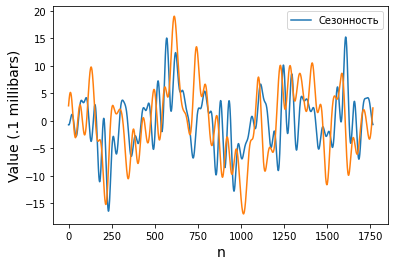

In [ ]:
x = range(len(dataseason_press))
plt.plot(dataseason_press, label="Сезонность")
plt.plot(sinusiod(x, spectre_jr[0], phases, frqs))
plt.legend()
plt.xlabel('n', fontsize=14)
plt.ylabel('Value (.1 millibars)', fontsize=14)

Text(0, 0.5, 'Value (.1 millibars)')

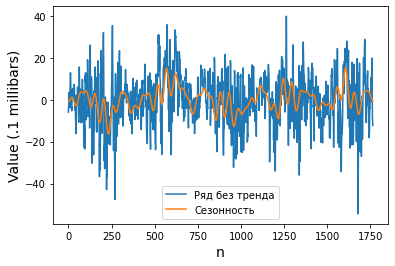

In [ ]:
plt.plot(datadetrend_press, label="Ряд без тренда")
plt.plot(dataseason_press, label="Сезонность")
plt.legend()
plt.xlabel('n', fontsize=14)
plt.ylabel('Value (.1 millibars)', fontsize=14)

In [ ]:
datastationary_press=datadetrend_press-dataseason_press
np.mean(datastationary_press)

5.96342281130965e-07

Критерий Дики-Фуллера: p=0.000000


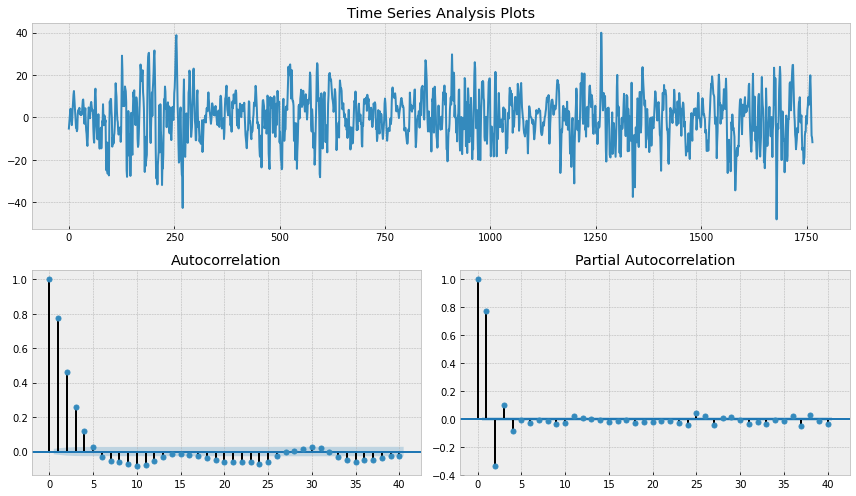

In [ ]:
tsplot(datastationary_press, lags=40)

In [ ]:
# Проверяем на стационарность. Считаем единичные корни

autoreg_model = AutoReg(datastationary_press, lags=20, trend='n')
autoreg_model_fit = autoreg_model.fit()

p = P(np.flip(np.append(autoreg_model_fit.params,1)))
print(abs(p.roots()))

print(autoreg_model_fit.params)

[0.97105237 0.97105237 0.97578915 0.97578915 0.97920672 0.97920672
 0.99408871 0.99408871 0.99552914 0.99552914 1.00706441 1.00706441
 1.00519056 1.00519056 1.01144472 1.01144472 1.01163623 1.01163623
 1.01589933 1.01589933]
[ 1.07114931e+00 -4.76631188e-01  1.96292787e-01 -9.50050644e-02
  2.21632431e-02 -2.38228608e-02 -3.37629695e-03  1.04920275e-02
  5.34127707e-03 -5.40264268e-02  1.72051403e-02  4.78778966e-03
 -4.46780053e-04  6.31015291e-03 -2.11941143e-03 -1.89595402e-02
  1.65841124e-02 -1.75011535e-02  5.94706301e-03 -2.07539376e-02]


Text(0, 0.5, 'Value (.1 millibars)')

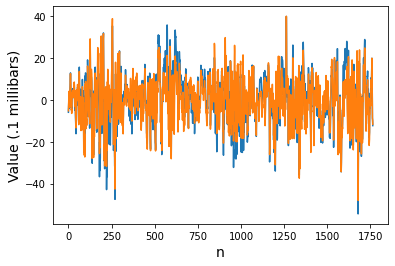

In [ ]:
plt.plot(datadetrend_press)
plt.plot(datastationary_press)
plt.xlabel('n', fontsize=14)
plt.ylabel('Value (.1 millibars)', fontsize=14)

In [ ]:
mean=np.mean(datastationary_press)
std=np.std(datastationary_press)

Критерий Дики-Фуллера: p=0.013331


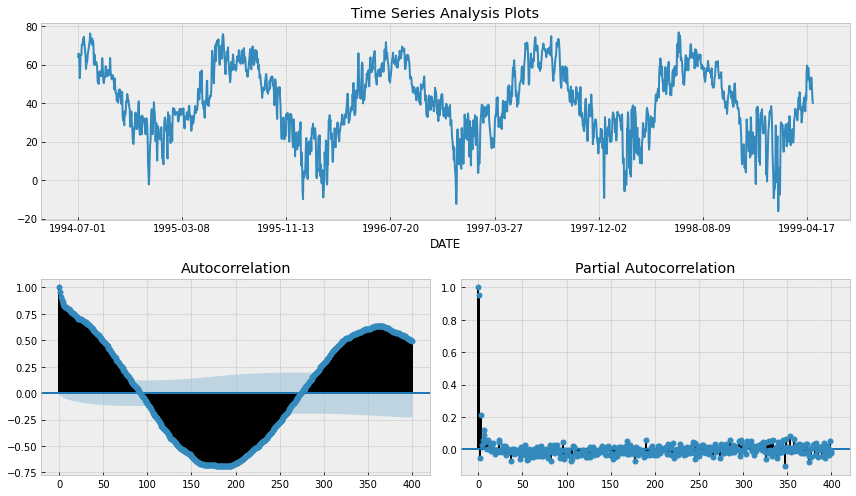

In [ ]:
tsplot(cut_data['TEMP'], lags=400)

In [ ]:
data_array = cut_data['TEMP']

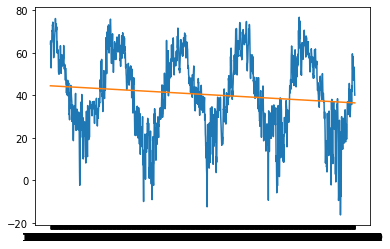

In [ ]:
degree = 1
plt.show()
opt=approximate_poly(degree,data_array)
polyplot(data_array,opt.x)

In [ ]:
print(square_func(opt.x, data = data_array))

753.5396951574971


In [ ]:
opt_coeffs=approximate_poly(degree,data_array).x
datatrend_temp=np.array([poly(opt_coeffs,t) for t in range(len(data_array))])
datadetrend_temp = np.array(data_array)-datatrend_temp

In [ ]:
spectre=np.fft.fft(datadetrend_temp)
np.mean(datadetrend_temp)

2.097111230154603e-06

In [ ]:
index_spectre = np.where(np.abs(spectre)/np.max(np.abs(spectre))>0.75)

In [ ]:
spectre_jr_temp = []
for index in index_spectre:
    spectre_jr_temp.append(np.abs(spectre[index]))

print(spectre_jr_temp)

[array([18895.55828022, 18895.55828022])]


In [ ]:
mainspectre=np.zeros(len(spectre),dtype=np.complex128)
mainspectre[np.abs(spectre)/np.max(np.abs(spectre))>0.75]=spectre[np.abs(spectre)/np.max(np.abs(spectre))>0.75]
dataseason_temp=np.real(np.fft.ifft(mainspectre))
datastationary_temp=datadetrend_temp-dataseason_temp
np.mean(datastationary_temp)

2.0971112302834266e-06

In [ ]:
frqs_temp = np.fft.fftfreq(len(spectre))
frqs_temp = frqs_temp[index_spectre]

phases_temp = []
for sp in spectre:
    phases_temp.append(cmath.phase(sp)) 

Text(0, 0.5, 'Value (.1 millibars)')

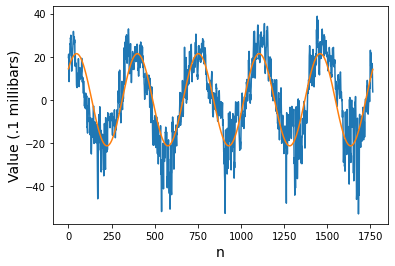

In [ ]:
plt.plot(datadetrend_temp)
plt.plot(dataseason_temp)
plt.xlabel('n', fontsize=14)
plt.ylabel('Value (.1 millibars)', fontsize=14)

Критерий Дики-Фуллера: p=0.000000


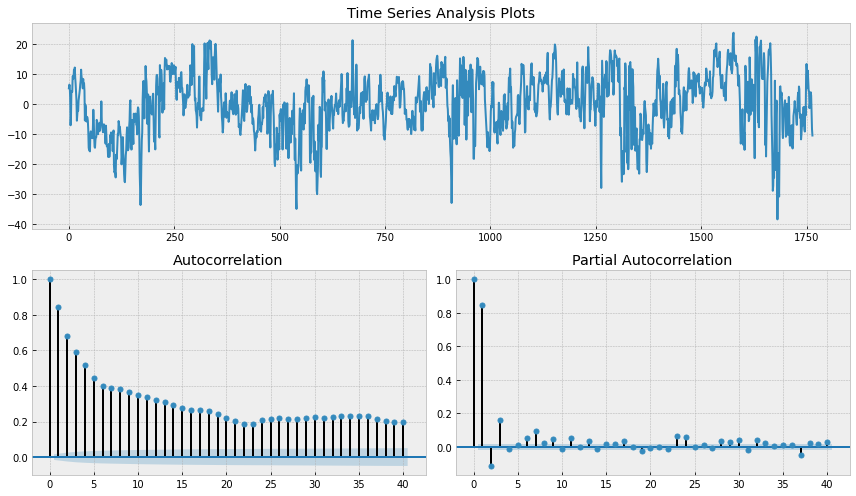

In [ ]:
tsplot(datastationary_temp, lags=40)

In [ ]:
def make_stationaly(pressure, opt_coeffs_press, phases, frqs, spectre_jr):
  datatrend = np.array([poly(opt_coeffs_press,t) for t in range(len(pressure))])
  datadetrend = np.array(pressure)-datatrend

  dataseason = sinusiod(range(len(pressure)), spectre_jr[0], phases, frqs)

  datastationary=datadetrend-dataseason
    
  return datastationary

In [ ]:
full_pres = make_stationaly(data['SLP'].values, opt_coeffs_press, phases, frqs, spectre_jr)

In [ ]:
full_temp = make_stationaly(data['TEMP'].values, opt_coeffs, phases_temp, frqs_temp, spectre_jr_temp)

# Строим авторегрессию

In [ ]:
def autoreg(X_train_autoreg, X_test_autoreg, lags, trend, exog_train=None, exog_test=None):    
    
    if exog_train is None:
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend)
        autoreg_model_fit = autoreg_model.fit()
        
        predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=False)
    else:                
        autoreg_model = AutoReg(X_train_autoreg, lags=lags, trend=trend, exog=exog_train)
        autoreg_model_fit = autoreg_model.fit()
        
        predictions = autoreg_model_fit.predict(start=len(X_train_autoreg)-1, 
                                end=len(X_test_autoreg)+len(X_train_autoreg)-2, dynamic=False, exog_oos=exog_test)
    
    predictions = -predictions
    rmse = sqrt(mean_squared_error(X_test_autoreg[:-1], predictions[1:]))
    mae = mean_absolute_error(X_test_autoreg[:-1], predictions[1:])
    
#     fig, ax = plt.subplots()

#     ax.plot(X_test_autoreg[:-1], label="Test")    
#     ax.plot(predictions[1:], label="Prediction")

#     ax.legend()
#     plt.show()
    
#     print("rmse", rmse)
#     print("mae", mae)
    
    return predictions, rmse, mae

In [ ]:
pressure = datastationary_press

prediction_size = 40
train_size = 100

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]

pred, rmse, mae = autoreg(X_train_autoreg, X_test_autoreg, 30, 'n')

In [ ]:
def inverse_changes(series, coeff, phases, frqs, ampl):
    return series + poly(coeff, series) + sinusiod(range(len(series)), ampl, phases, frqs)

In [ ]:
predictions = inverse_changes(pred, opt_coeffs_press, phases, frqs, spectre_jr[0])
X_test_autoreg = cut_data['SLP'][len(pressure)-prediction_size:]

rmse 11.654328244815813
mae 8.693963629272858


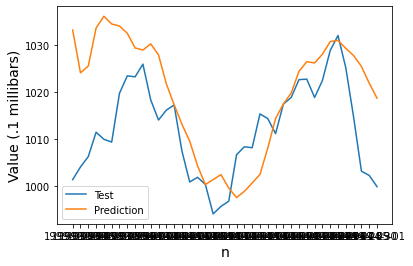

In [ ]:
plt.plot(X_test_autoreg, label="Test")
plt.plot(predictions, label="Prediction")
plt.legend()
plt.xlabel('n', fontsize=14)
plt.ylabel('Value (.1 millibars)', fontsize=14)

rmse = sqrt(mean_squared_error(X_test_autoreg[:-1], predictions[1:]))
mae = mean_absolute_error(X_test_autoreg[:-1], predictions[1:])

print("rmse", rmse)
print("mae", mae)

In [ ]:
pressure = datastationary_press

prediction_size = 100
train_size = 150

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]

pred, rmse, mae = autoreg(X_train_autoreg, X_test_autoreg, 40, 'n')

rmse 14.443470681658514
mae 11.502310508401267


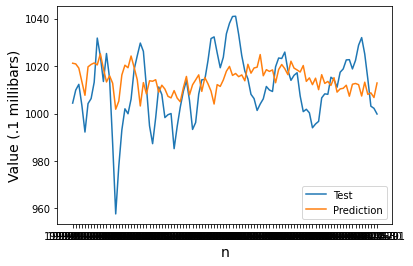

In [ ]:
predictions = inverse_changes(pred, opt_coeffs_press, phases, frqs, spectre_jr[0])
X_test_autoreg = cut_data['SLP'][len(pressure)-prediction_size:]

plt.plot(X_test_autoreg, label="Test")
plt.plot(predictions, label="Prediction")
plt.legend()
plt.xlabel('n', fontsize=14)
plt.ylabel('Value (.1 millibars)', fontsize=14)

rmse = sqrt(mean_squared_error(X_test_autoreg[:-1], predictions[1:]))
mae = mean_absolute_error(X_test_autoreg[:-1], predictions[1:])

print("rmse", rmse)
print("mae", mae)

In [ ]:
pressure = datastationary_press
temp = datastationary_temp

prediction_size = 40
train_size = 100

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]

X_train_exog, X_test_exog = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
pressure[len(temp)-prediction_size:]

pred, rmse, mae = autoreg(X_train_autoreg, X_test_autoreg, 30, 'n', X_train_exog, X_test_exog)

rmse 10.53284746247381
mae 8.13092290616586


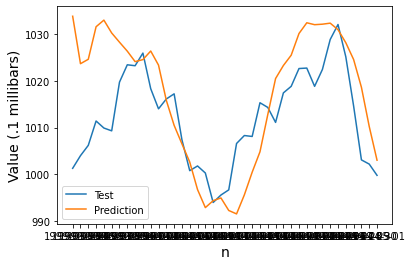

In [ ]:
predictions = inverse_changes(pred, opt_coeffs_press, phases, frqs, spectre_jr[0])
X_test_autoreg = cut_data['SLP'][len(pressure)-prediction_size:]

plt.plot(X_test_autoreg, label="Test")
plt.plot(predictions, label="Prediction")
plt.legend()
plt.xlabel('n', fontsize=14)
plt.ylabel('Value (.1 millibars)', fontsize=14)

rmse = sqrt(mean_squared_error(X_test_autoreg[:-1], predictions[1:]))
mae = mean_absolute_error(X_test_autoreg[:-1], predictions[1:])

print("rmse", rmse)
print("mae", mae)

In [ ]:
pressure = datastationary_press

prediction_size = 100
train_size = 150

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]

X_train_exog, X_test_exog = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
pressure[len(temp)-prediction_size:]

pred, rmse, mae = autoreg(X_train_autoreg, X_test_autoreg, 40, 'n', X_train_exog, X_test_exog)

rmse 10.455938668204949
mae 8.426211866789018


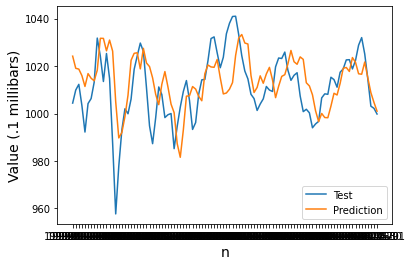

In [ ]:
predictions = inverse_changes(pred, opt_coeffs_press, phases, frqs, spectre_jr[0])
X_test_autoreg = cut_data['SLP'][len(pressure)-prediction_size:]

plt.plot(X_test_autoreg, label="Test")
plt.plot(predictions, label="Prediction")
plt.legend()
plt.xlabel('n', fontsize=14)
plt.ylabel('Value (.1 millibars)', fontsize=14)

rmse = sqrt(mean_squared_error(X_test_autoreg[:-1], predictions[1:]))
mae = mean_absolute_error(X_test_autoreg[:-1], predictions[1:])

print("rmse", rmse)
print("mae", mae)

# Кросс-валидация

In [ ]:
def cross_autoreg(pressure, true_pres, prediction_size, train_size, lags, temp=None):
    errors = [[],[]]

    for i in range(0, len(pressure)-train_size-prediction_size, int(train_size/2)):
        X_train_autoreg = pressure[i:i+train_size]
        X_test_autoreg = pressure[i+train_size:i+train_size+prediction_size]
        
        if temp is not None:            
            exog_train = temp[i:i+train_size]
            exog_test = temp[i+train_size:i+train_size+prediction_size]  
            pred, rmse, mae = autoreg(X_train_autoreg, X_test_autoreg, lags, 'n', exog_train, exog_test)
        
        else:
            pred, rmse, mae = autoreg(X_train_autoreg, X_test_autoreg, lags, 'n')
        
        predictions = inverse_changes(pred, opt_coeffs_press, phases, frqs, spectre_jr[0])
        X_test_autoreg = true_pres[i+train_size:i+train_size+prediction_size]
        
        rmse = sqrt(mean_squared_error(X_test_autoreg[:-1], predictions[1:]))
        mae = mean_absolute_error(X_test_autoreg[:-1], predictions[1:])
        
        errors[0].append(rmse)
        errors[1].append(mae)

    # Вычисление средних оценок.
    errors_mean = [sum(errors[0])/len(errors[0]), sum(errors[1])/len(errors[1])]
    
    return errors_mean, errors[0], errors[1]

In [ ]:
errors_mean, rmse, mae = cross_autoreg(full_pres, data['SLP'].values, 40, 50, 16)

Средняя rmse 21.5049420208643
Средняя mse 17.622525167657233


Text(0, 0.5, 'rmse')

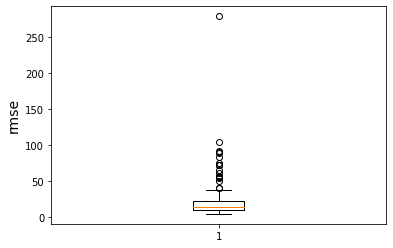

In [ ]:
print("Средняя rmse", errors_mean[0])
print("Средняя mse", errors_mean[1])

plt.boxplot(rmse)
plt.ylabel('rmse', fontsize=14)

Text(0, 0.5, 'mae')

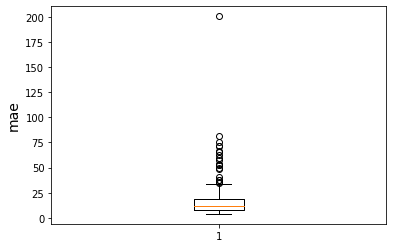

In [ ]:
plt.boxplot(mae)
plt.ylabel('mae', fontsize=14)

In [ ]:
errors_mean, rmse, mae = cross_autoreg(full_pres, data['SLP'].values, 100, 150, 8, full_temp)

Средняя rmse 13.418976208914478
Средняя mse 10.970647225040828


Text(0, 0.5, 'rmse')

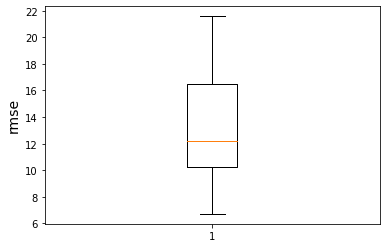

In [ ]:
print("Средняя rmse", errors_mean[0])
print("Средняя mse", errors_mean[1])

plt.boxplot(rmse)
plt.ylabel('rmse', fontsize=14)

Text(0, 0.5, 'mae')

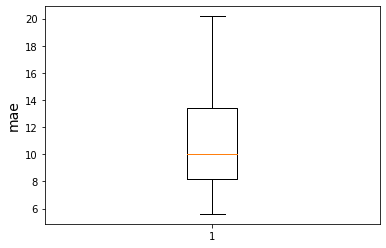

In [ ]:
plt.boxplot(mae)
plt.ylabel('mae', fontsize=14)

# Медиана (+проверка на рандомных пропусках)

In [ ]:
missing_vals['SLP'] = data['SLP'].median()

filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

[]

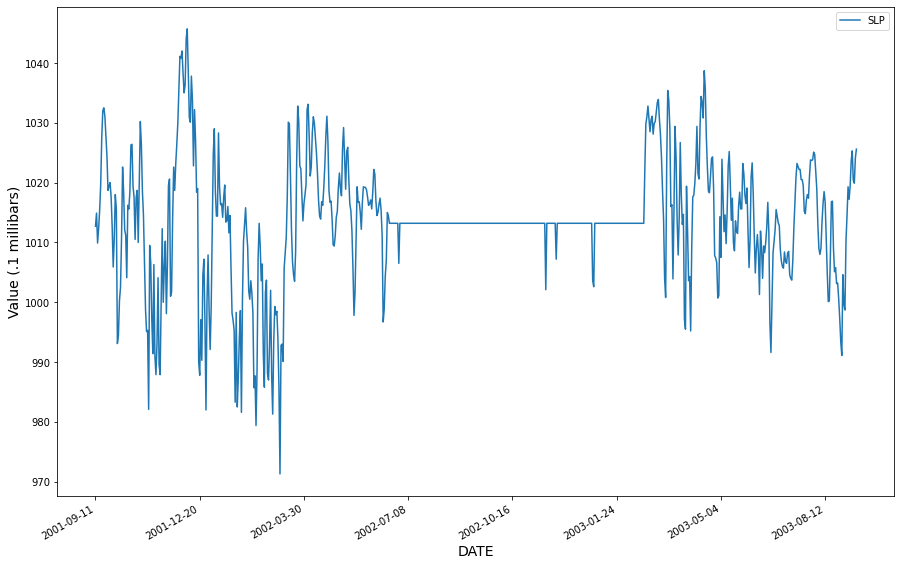

In [ ]:
filled_data.SLP['2001-09-11':'2003-09-11'].plot(subplots=True, figsize=(15, 10), label="SLP")
plt.legend()
plt.xlabel('DATE', fontsize=14)
plt.ylabel('Value (.1 millibars)', fontsize=14)
plt.plot()

Text(0, 0.5, 'Value (.1 millibars)')

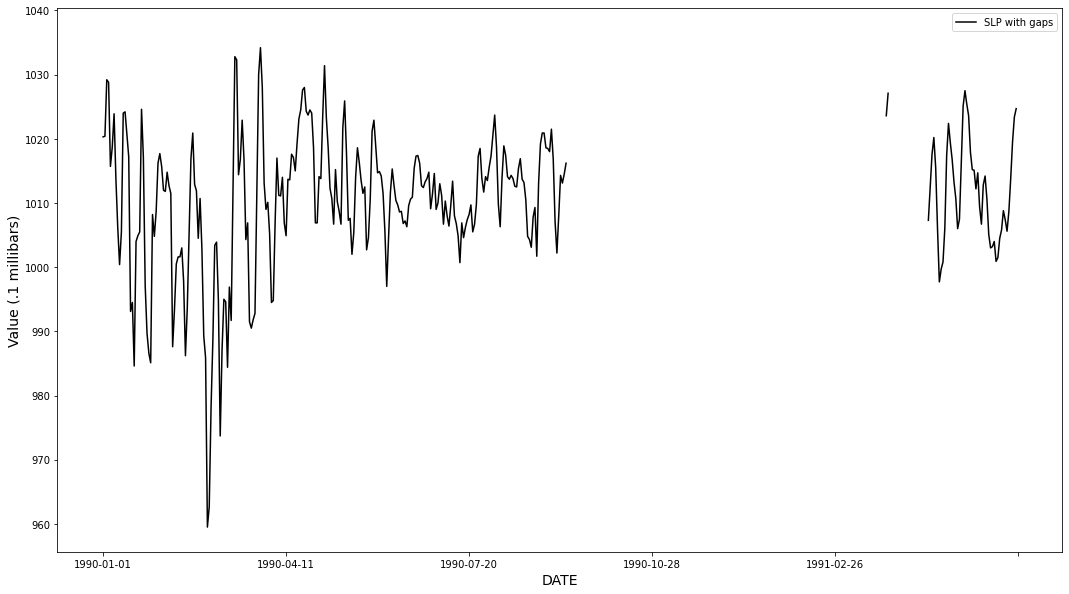

In [ ]:
random_missing = data.copy()
random_missing = random_missing[:500]

index_df = missing_vals['2001-09-11':'2003-09-11'].copy()
index_df.index = pd.to_datetime(index_df.index)
index_df = index_df.shift(-(12*365)+np.random.randint(1,6*30), freq='D') # делаем такой же пропуск в рандомном месте +-6 месяцев

gaps_index = index_df.index.strftime("%Y-%m-%d").to_list()

random_missing.at[random_missing.index.intersection(gaps_index), "SLP"] = np.nan
random_missing = random_missing.sort_index()
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP with gaps')
plt.legend()
plt.xlabel('DATE', fontsize=14)
plt.ylabel('Value (.1 millibars)', fontsize=14)

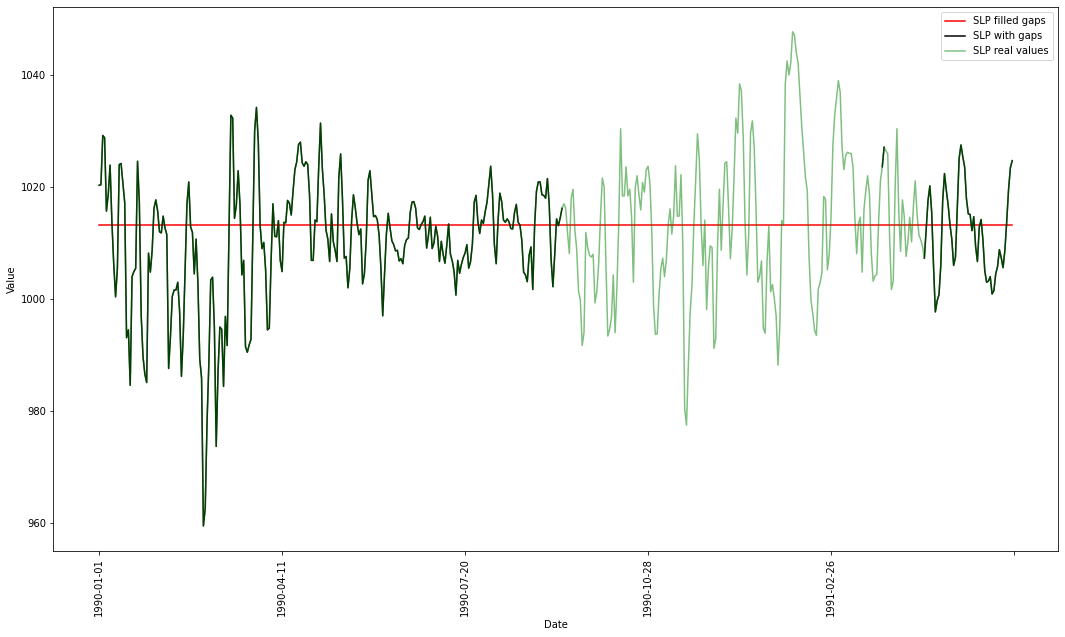

random gaps rmse:  11.727464346566997 mae:  8.685800000000002


In [ ]:
filled = random_missing.copy()
filled['SLP'] = data['SLP'].median()

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled gaps')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP with gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

In [ ]:
transf_temp = make_stationaly(filled_data.TEMP, opt_coeffs, phases_temp, frqs_temp, spectre_jr_temp)
transf_filled_data = make_stationaly(filled_data.SLP, opt_coeffs_press, phases, frqs, spectre_jr)

In [ ]:
errors_mean, rmse, mae = cross_autoreg(transf_filled_data, filled_data.SLP, 100, 150, 7, transf_temp)

In [ ]:
rmse_fr = pd.DataFrame()
mae_fr = pd.DataFrame()

In [ ]:
print("Средняя rmse", errors_mean[0])
print("Средняя mae", errors_mean[1])

rmse_fr['Median'] = rmse
mae_fr['Median'] = mae

Средняя rmse 14.351265668407974
Средняя mae 11.845364663996158


# Линейная интерполяция (проверка на рандомных пропусках)

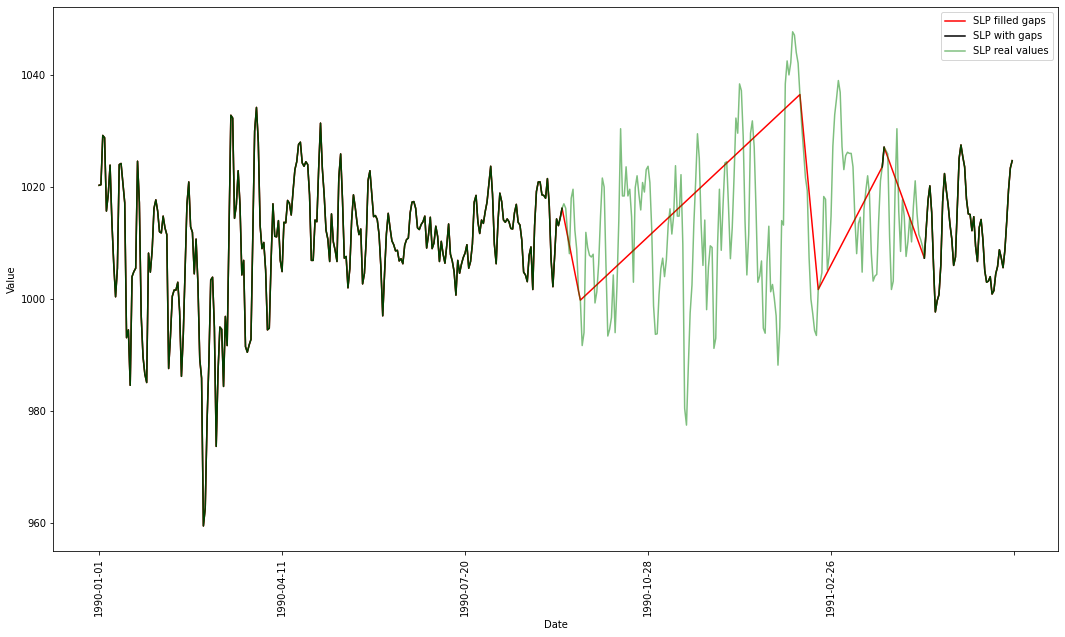

random gaps rmse:  8.91552130138203 mae:  4.21145857142857


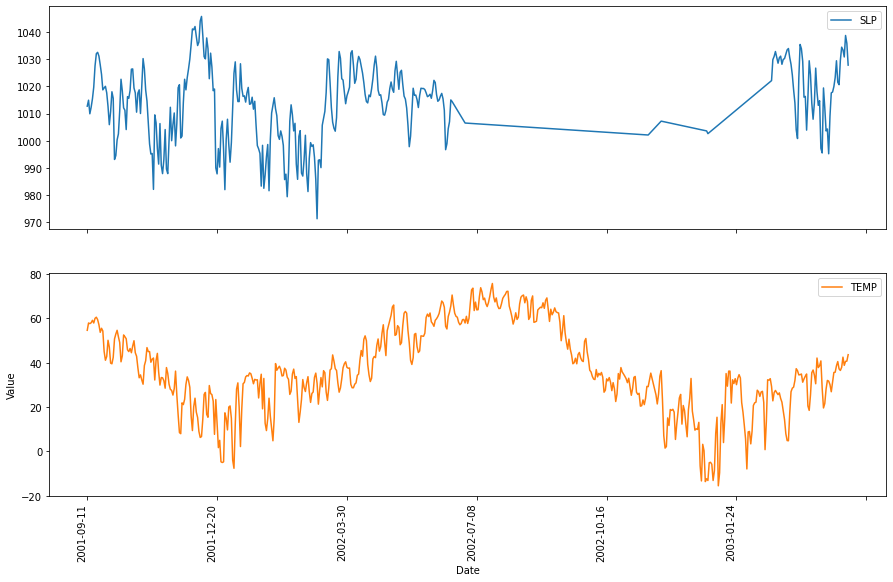

In [ ]:
missing_nan = original_data.copy()
missing_nan = missing_nan.replace(9999.9, np.nan, regex=True)

filled = random_missing.copy()
filled['SLP'] = filled[['SLP']].interpolate(method='linear')['SLP']

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled gaps')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP with gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')

plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

missing_interpolate = missing_nan[['SLP']].interpolate(method='linear')['SLP']
missing_vals['SLP'] = missing_interpolate

filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

prediction_size = 40
train_size = 40

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

In [ ]:
transf_temp = make_stationaly(filled_data.TEMP, opt_coeffs, phases_temp, frqs_temp, spectre_jr_temp)
transf_filled_data = make_stationaly(filled_data.SLP, opt_coeffs_press, phases, frqs, spectre_jr)

errors_mean, rmse, mae = cross_autoreg(transf_filled_data, filled_data.SLP, 100, 150, 2, transf_temp)

print("Средняя rmse", errors_mean[0])
print("Средняя mae", errors_mean[1])

rmse_fr['Linear'] = rmse
mae_fr['Linear'] = mae

Средняя rmse 14.280549133787053
Средняя mae 11.911012704459202


# Интерполяция сплайнами

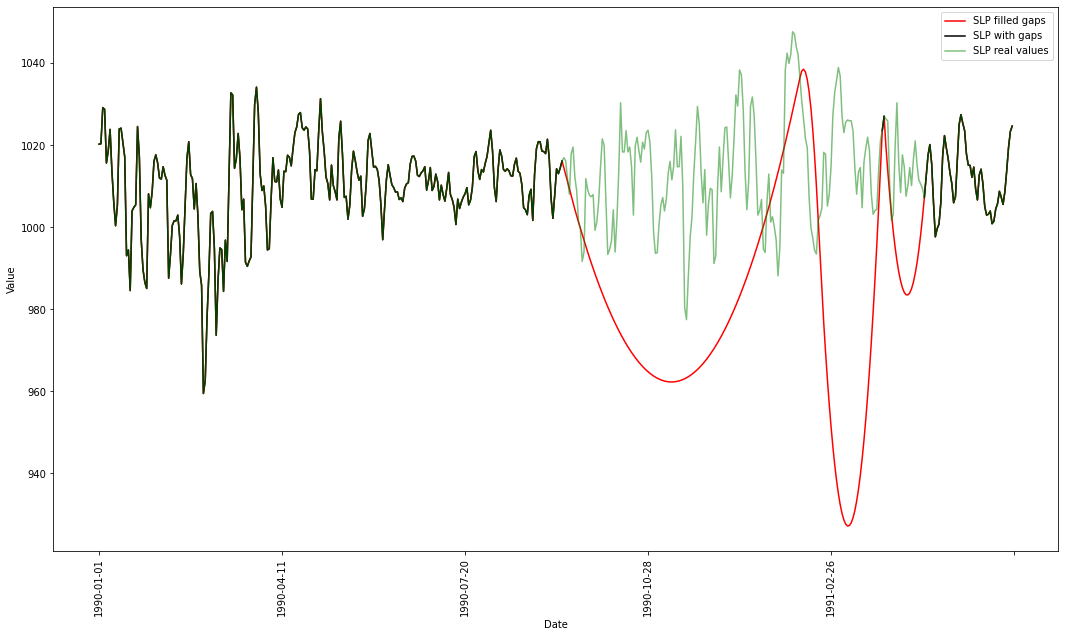

random gaps rmse:  26.458061223495037 mae:  13.439031269467494


In [ ]:
s = pd.Series(random_missing["SLP"].values)
filled['SLP'] = s.interpolate(method='spline', order=2).values

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled gaps')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP with gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

In [ ]:
missing_spline = missing_nan.copy()
s = pd.Series(missing_spline["SLP"].values)

missing_spline['SLP'] = s.interpolate(method='spline', order=3).values
missing_vals['SLP'] = missing_spline

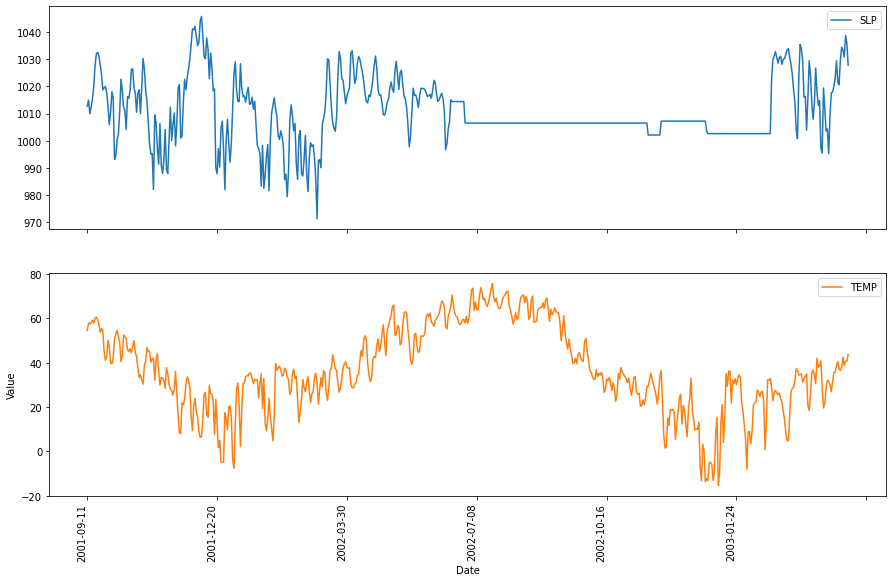

In [ ]:
filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

In [ ]:
transf_temp = make_stationaly(filled_data.TEMP, opt_coeffs, phases_temp, frqs_temp, spectre_jr_temp)
transf_filled_data = make_stationaly(filled_data.SLP, opt_coeffs_press, phases, frqs, spectre_jr)

errors_mean, rmse, mae = cross_autoreg(transf_filled_data, filled_data.SLP, 100, 150, 5, transf_temp)

print("Средняя rmse", errors_mean[0])
print("Средняя mae", errors_mean[1])

rmse_fr['Spline'] = rmse
mae_fr['Spline'] = mae

Средняя rmse 14.665418156519046
Средняя mae 12.242957452729879


#<h2>KNN</h2>

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

missing_knn = missing_nan.copy()
missing_knn['SLP'] = imputer.fit_transform(missing_knn)
missing_vals['SLP'] = missing_knn

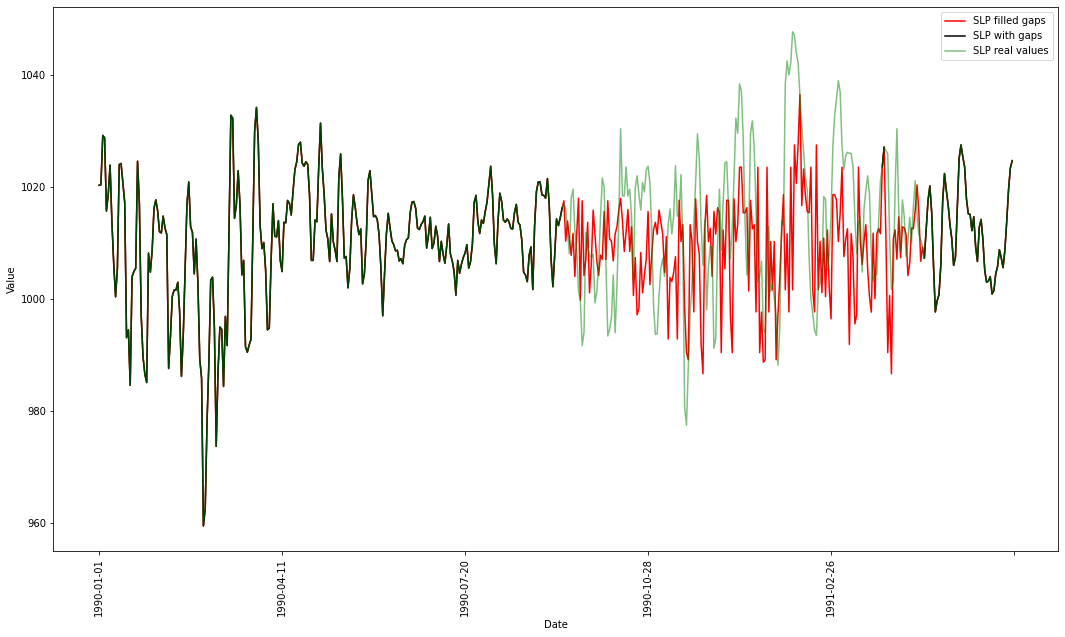

random gaps rmse:  8.747607037864068 mae:  4.358600000000002


In [ ]:
filled = random_missing.copy()
filled['SLP'] = imputer.fit_transform(filled)

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled gaps')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP with gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

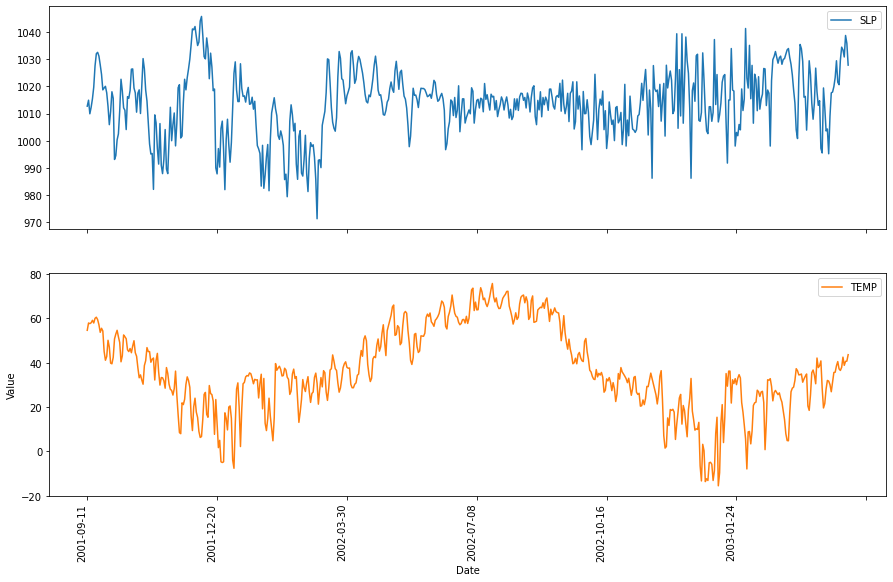

In [ ]:
filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

In [ ]:
transf_temp = make_stationaly(filled_data.TEMP, opt_coeffs, phases_temp, frqs_temp, spectre_jr_temp)
transf_filled_data = make_stationaly(filled_data.SLP, opt_coeffs_press, phases, frqs, spectre_jr)

errors_mean, rmse, mae = cross_autoreg(transf_filled_data, filled_data.SLP, 100, 150, 6, transf_temp)

print("Средняя rmse", errors_mean[0])
print("Средняя mae", errors_mean[1])

rmse_fr['KNN'] = rmse
mae_fr['KNN'] = mae

Средняя rmse 14.339695414909242
Средняя mae 11.857981855377927


# Итеративное заполнение

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

missing_inter = missing_nan.copy()
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(data.dropna())

missing_inter['SLP'] = imp_mean.transform(missing_inter)
missing_vals['SLP'] = missing_inter

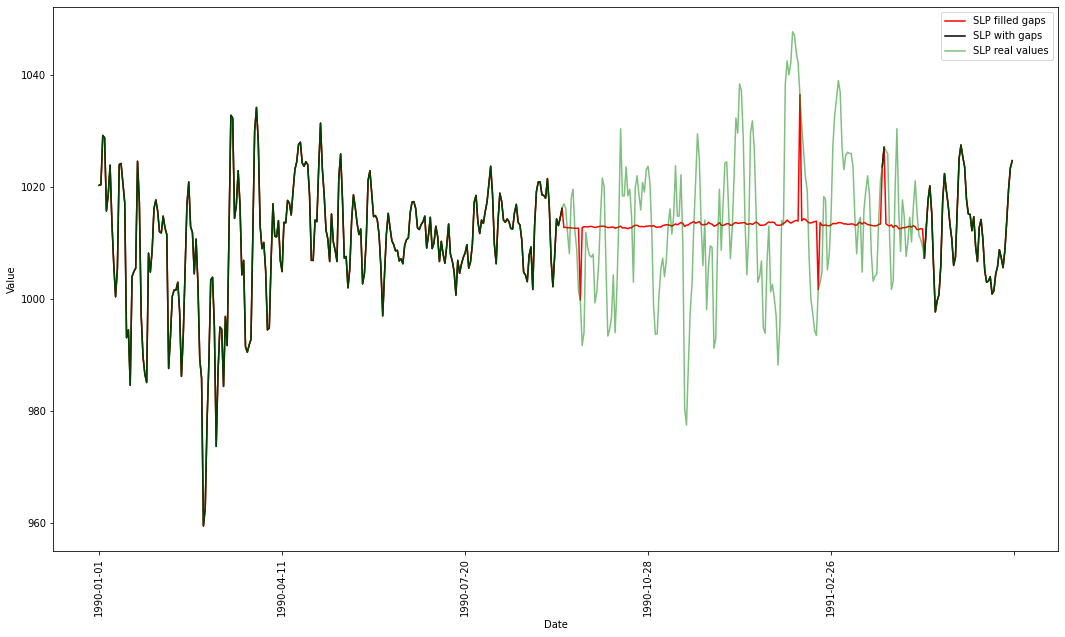

random gaps rmse:  7.864474196468526 mae:  3.8212875897655065


In [ ]:
filled = random_missing.copy()
filled['SLP'] = imp_mean.transform(filled)

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled gaps')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP with gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

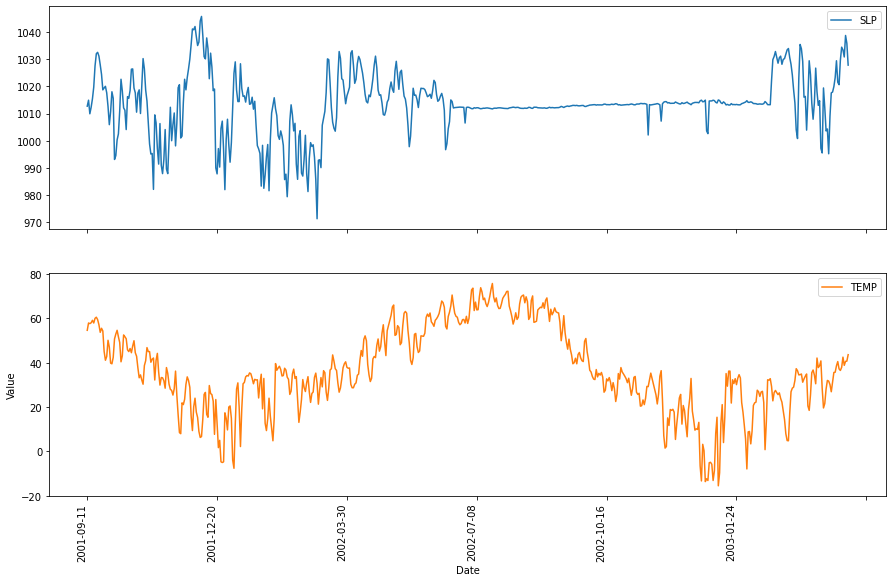

In [ ]:
filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()

filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

In [ ]:
transf_temp = make_stationaly(filled_data.TEMP, opt_coeffs, phases_temp, frqs_temp, spectre_jr_temp)
transf_filled_data = make_stationaly(filled_data.SLP, opt_coeffs_press, phases, frqs, spectre_jr)

errors_mean, rmse, mae = cross_autoreg(transf_filled_data, filled_data.SLP, 100, 150, 6, transf_temp)

print("Средняя rmse", errors_mean[0])
print("Средняя mae", errors_mean[1])

rmse_fr['Iterative'] = rmse
mae_fr['Iterative'] = mae

Средняя rmse 14.166221603049195
Средняя mae 11.725085371049543


#<h2>Использование фильтра Савицкого-Голэя</h2>

In [ ]:
from scipy.signal import savgol_filter

missing_savgol = missing_nan.copy()
s = pd.Series(missing_savgol["SLP"].values)

missing_savgol['SLP'] = savgol_filter(s.interpolate(method='linear', order=1).values,mode='nearest', window_length=7, polyorder=2)
missing_vals['SLP'] = missing_savgol

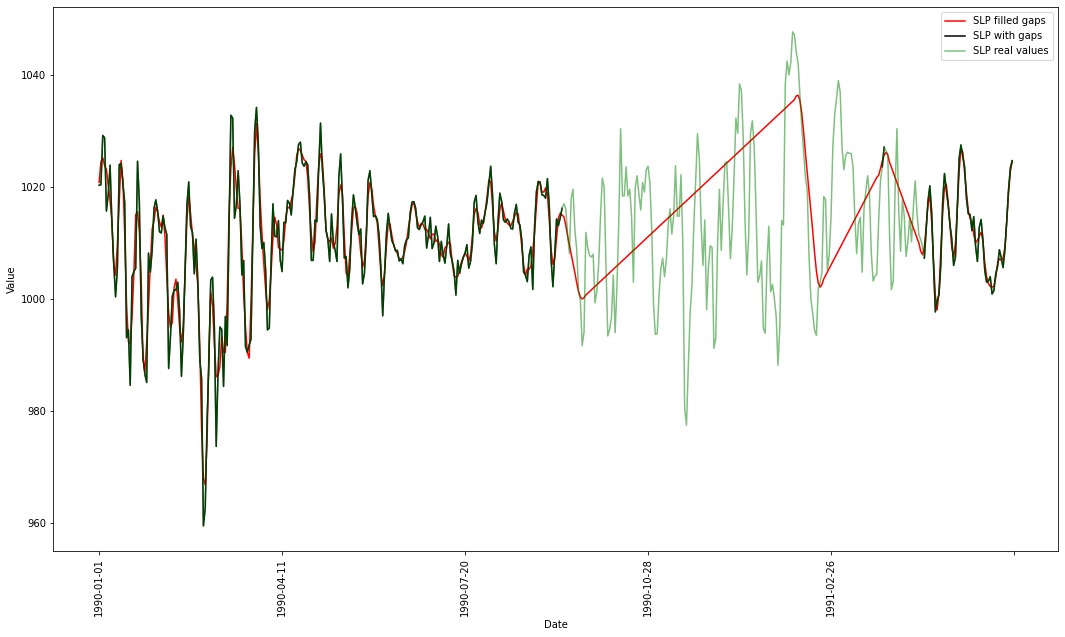

random gaps rmse:  9.263510894297434 mae:  5.645956666666683


In [ ]:
s = pd.Series(random_missing["SLP"].values)
filled['SLP'] = savgol_filter(s.interpolate(method='linear', order=1).values,mode='nearest', window_length=7, polyorder=2)

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled gaps')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP with gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

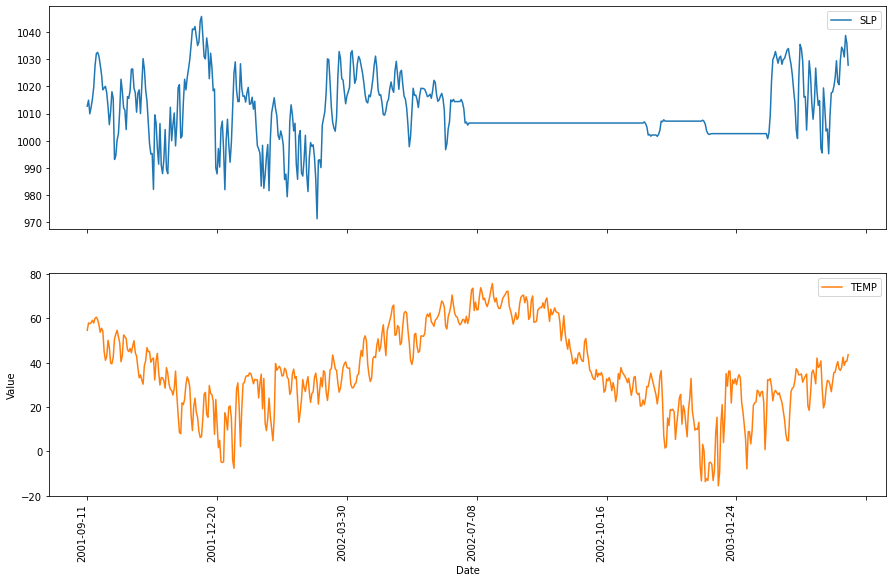

In [ ]:
filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()
filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

In [ ]:
transf_temp = make_stationaly(filled_data.TEMP, opt_coeffs, phases_temp, frqs_temp, spectre_jr_temp)
transf_filled_data = make_stationaly(filled_data.SLP, opt_coeffs_press, phases, frqs, spectre_jr)

errors_mean, rmse, mae = cross_autoreg(transf_filled_data, filled_data.SLP, 100, 150, 5, transf_temp)

print("Средняя rmse", errors_mean[0])
print("Средняя mae", errors_mean[1])

rmse_fr['Savitzky–Golay'] = rmse
mae_fr['Savitzky–Golay'] = mae

Средняя rmse 14.636637703556936
Средняя mae 12.221542155757412


#<h2>LOCF</h2>

In [ ]:
missing_locf = missing_nan
missing_locf['SLP'] = missing_nan.fillna(method='ffill')
missing_vals['SLP'] = missing_locf

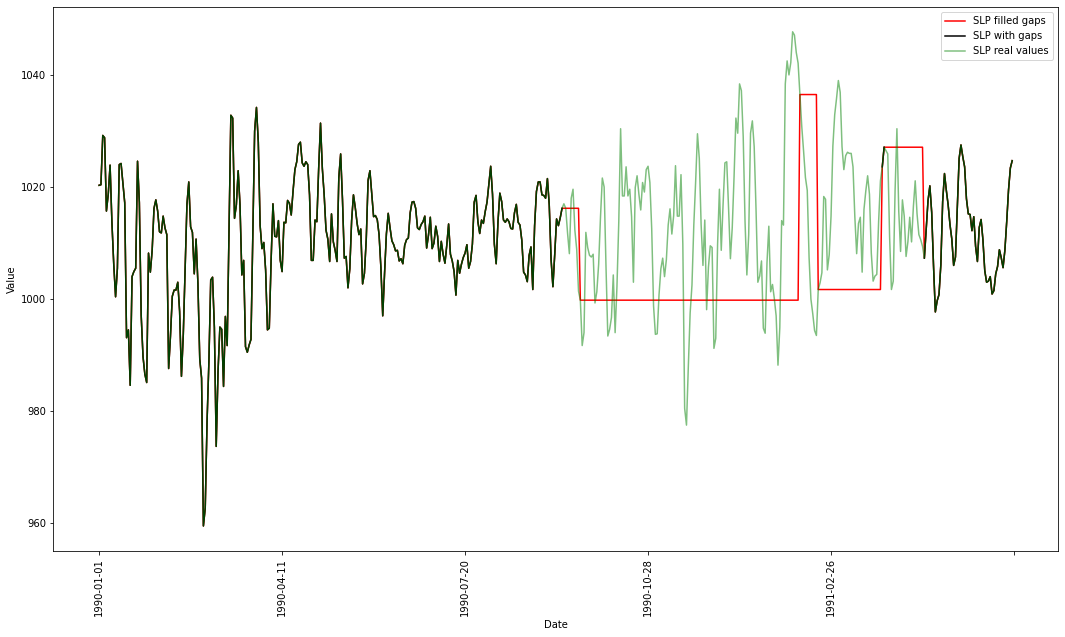

random gaps rmse:  11.755083155809665 mae:  5.879


In [ ]:
filled = random_missing.copy()
filled['SLP'] = filled.fillna(method='ffill')

filled.SLP.plot(figsize=(18, 10),color='red', label = 'SLP filled gaps')
random_missing.SLP.plot(figsize=(18, 10),color='black', label = 'SLP with gaps')
data[:500].SLP.plot(figsize=(18, 10),color='green',alpha = 0.5, label = 'SLP real values')
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

rmse = sqrt(mean_squared_error(data[:500].SLP, filled.SLP))
mae = mean_absolute_error(data[:500].SLP, filled.SLP)
print("random gaps rmse: ", rmse, "mae: ", mae)

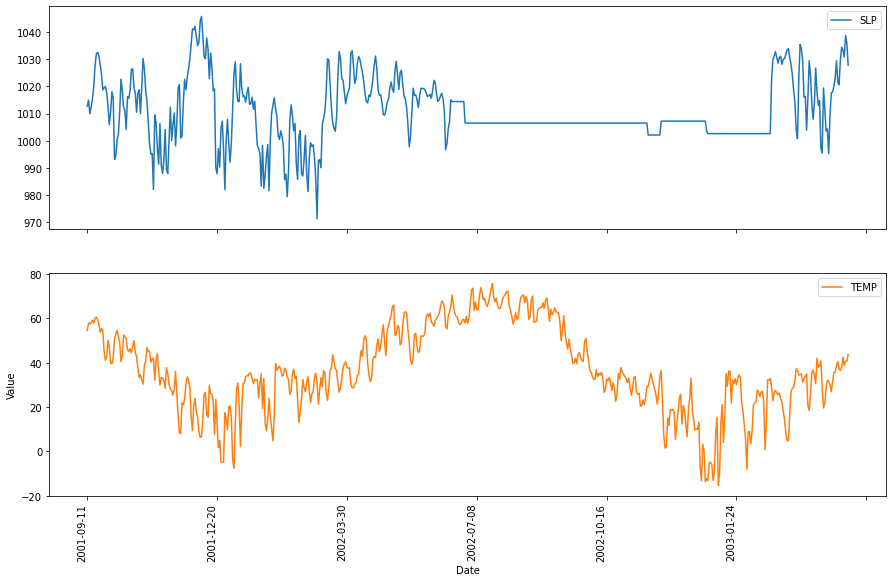

In [ ]:
filled_data = pd.concat([data, missing_vals])
filled_data = filled_data.sort_index()
filled_data['2001-09-11':'2003-04-20'].plot(subplots=True, figsize=(15, 10))
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

X_train_autoreg, X_test_autoreg = pressure[len(pressure)-train_size-prediction_size:len(pressure)-prediction_size],\
pressure[len(pressure)-prediction_size:]
exog_train, exog_test = temp[len(temp)-train_size-prediction_size:len(temp)-prediction_size],\
temp[len(temp)-prediction_size:]
predictions = autoreg(X_train_autoreg, X_test_autoreg, 16, 'n', exog_train, exog_test)

In [ ]:
transf_temp = make_stationaly(filled_data.TEMP, opt_coeffs, phases_temp, frqs_temp, spectre_jr_temp)
transf_filled_data = make_stationaly(filled_data.SLP, opt_coeffs_press, phases, frqs, spectre_jr)

errors_mean, rmse, mae = cross_autoreg(transf_filled_data, filled_data.SLP, 100, 150, 6, transf_temp)

print("Средняя rmse", errors_mean[0])
print("Средняя mae", errors_mean[1])

rmse_fr['LOCF'] = rmse
mae_fr['LOCF'] = mae

Средняя rmse 14.792822985080193
Средняя mae 12.342454764147963


Text(0, 0.5, 'rmse')

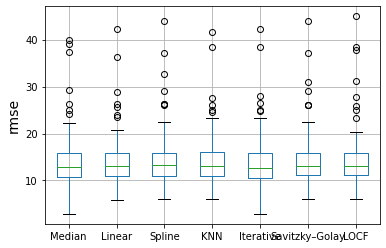

In [ ]:
rmse_fr.boxplot()
plt.ylabel('rmse', fontsize=14)

Text(0, 0.5, 'mae')

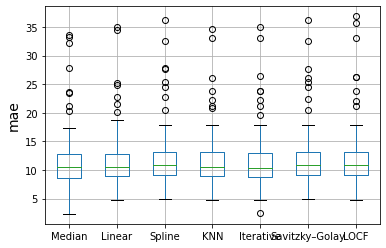

In [ ]:
mae_fr.boxplot()
plt.ylabel('mae', fontsize=14)